Este notebook está destinado a realizar el analisis, exploracioón, transformación de los archivos dados y datos crudos con el fin de generar datos de calidad para su posterior analisis y realización de los archivos necesarios para el entrenamiento del model de Machine Learning y cumplimentar las funciones solicitadas para la API.

Cargo las librerías necesarias para la ejecución de las tareas

In [22]:
import pandas as pd
import numpy as np
import ast
import json
import chardet
import re
from textblob import TextBlob
import pyarrow
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from wordcloud import WordCloud


Defino funciones que utilizaré para: 
* Detectar el encoding de los archivos 
* Detectar duplicados que puedan encontrarse en los dataframes
* Analizar sentimientos
* Verificar lineas nulas
* Obtener fila por ìndice
* Extraer solo el año

In [23]:
def cod_indentif(file_path):
    with open(file_path, 'rb') as file:
        result = chardet.detect(file.read())
    return result['encoding']

In [24]:
def duplicates(df, columns):
    duplicated = df[df.duplicated(subset=columns, keep=False)]
    if duplicated.empty:
        return "Non duplicates"
        
    duplicated2 = duplicated.sort_values(by=columns)
    return duplicated2


In [25]:
# Función para analizar sentimientos
def sentiment_analysis(comentario):
    analysis = TextBlob(str(comentario))
    # Devuelve un valor entre -1 y 1, donde -1 es negativo, 0 es neutro, y 1 es positivo
    return analysis.sentiment.polarity

In [26]:
# Función para verificar si una línea es nula
def es_nulo(dataframe, indice):
    fila = dataframe.loc[indice]
    if fila.isnull().any():
        print(f"La fila {indice} contiene al menos un valor nulo.")
        return True
    else:
        print(f"La fila {indice} no contiene valores nulos.")
        return False

In [27]:
def obtener_fila_por_indice(dataframe, indice):
    fila = dataframe.loc[indice]
    return fila

In [28]:
def extraer_anio(fecha):
    try:
        # Convertir la fecha a formato datetime y extraer el año
        return pd.to_datetime(fecha).year
    except:
        # Manejar casos en los que la fecha no sea válida
        return None

In [29]:
def indices_con_nulos_en_columna(dataframe, columna):
    indices_nulos = dataframe[dataframe[columna].isnull()].index
    return indices_nulos

In [30]:
# Función para asignar etiquetas de sentimiento
def asignar_etiqueta(sentimiento):
    if sentimiento > 0:
        return "positivo"
    elif sentimiento == 0:
        return "neutro"
    else:
        return "negativo"

Realizo la detección del encoding y la carga de los 3 archivos necesarios, transformándolos a Data Frames y observando la cantidad de Lineas y Columnas que posee.

In [31]:
file_path = './Data/output_steam_games.json'
encoding = cod_indentif(file_path)
print(encoding)

ascii


In [32]:
file_path = './Data/australian_user_reviews.json'
encoding = cod_indentif(file_path)
print(encoding)

Windows-1254


In [33]:
file_path = './Data/australian_users_items.json'
encoding = cod_indentif(file_path)
print(encoding)

Windows-1254


In [34]:
steamgames = []
with open('./Data/output_steam_games.json', 'r') as file:
        for line in file:
            obj = json.loads(line)
            steamgames.append(obj)
              
            
sgames = pd.DataFrame(steamgames)
print(sgames.shape)

(120445, 13)


In [35]:
reviews = []
with open('./Data/australian_user_reviews.json', 'r') as file:
        for line in file:
            datos = ast.literal_eval(line)
            reviews.append(datos)
           
ureviews = pd.DataFrame(reviews)
print(ureviews.shape)

(25799, 3)


In [36]:
items = []
with open('./Data/australian_users_items.json', 'r') as file:
    for line in file:
        datos = ast.literal_eval(line)
        items.append(datos)

uitems = pd.DataFrame(items)
print(uitems.shape)

(88310, 5)


Comienzo con el análisis y transformación del Data Frame que surge del archivo "output_steam_games.json"

In [37]:
sgames.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
sgames.tail()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
120440,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS"""
120441,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada
120442,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich
120443,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns"
120444,NaN,NaN,Maze Run VR,NaN,http://store.steampowered.com/app/681550/Maze_...,NaN,"[Early Access, Adventure, Indie, Action, Simul...",http://steamcommunity.com/app/681550/reviews/?...,"[Single-player, Stats, Steam Leaderboards, HTC...",4.99,True,681550,NaN


In [39]:
sgames.columns

Index(['publisher', 'genres', 'app_name', 'title', 'url', 'release_date',
       'tags', 'reviews_url', 'specs', 'price', 'early_access', 'id',
       'developer'],
      dtype='object')

In [40]:
sgames = sgames.dropna(how='all').reset_index(drop=True) #Elimino las lineas que poseen datos vacios ya que no van a aportar nada

In [41]:
sgames.head() #Observo como quedaron las primeras lineas

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN


In [42]:
print(sgames.shape) #Observo que cantidad de filas y columnas quedaron

(32135, 13)


In [43]:
duplicates(sgames, 'id') #utilizo la función para detectar duplicados por ID

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
13894,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,612880,Machine Games
14573,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,612880,Machine Games
74,NaN,NaN,NaN,NaN,http://store.steampowered.com/,NaN,NaN,NaN,NaN,19.99,False,NaN,NaN
30961,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham City - Game of the Year Edition,Batman: Arkham City - Game of the Year Edition,http://store.steampowered.com/app/200260,2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",NaN,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,NaN,"Rocksteady Studios,Feral Interactive (Mac)"


In [44]:
delete = [14573, 74, 30961] #Elimino los duplicado ya que considero que no van a aportar nada y es imposible arreglar los faltantes del ID
sgames = sgames.drop(delete)

In [45]:
duplicates(sgames, 'id') #Reviso nuevamente los duplicados

'Non duplicates'

In [46]:
nulls = sgames.isnull().sum()  #Veo los nulos de cada columna
print(nulls)

publisher       8051
genres          3282
app_name           1
title           2049
url                0
release_date    2066
tags             162
reviews_url        0
specs            669
price           1377
early_access       0
id                 0
developer       3298
dtype: int64


In [47]:
sgames.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32132 entries, 0 to 32134
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24081 non-null  object
 1   genres        28850 non-null  object
 2   app_name      32131 non-null  object
 3   title         30083 non-null  object
 4   url           32132 non-null  object
 5   release_date  30066 non-null  object
 6   tags          31970 non-null  object
 7   reviews_url   32132 non-null  object
 8   specs         31463 non-null  object
 9   price         30755 non-null  object
 10  early_access  32132 non-null  object
 11  id            32132 non-null  object
 12  developer     28834 non-null  object
dtypes: object(13)
memory usage: 3.4+ MB


In [48]:
sgames[sgames['id'].duplicated()] # Observo duplicados en columna ID

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer


In [49]:
rows_nan = sgames[sgames['id'].isna()] # Obervo lineas vacias en columna ID
rows_nan

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer


In [50]:
sgames['price'].unique() #Observo la columna "price"

array([4.99, 'Free To Play', 'Free to Play', 0.99, 2.99, 3.99, 9.99,
       18.99, 29.99, nan, 'Free', 10.99, 1.59, 14.99, 1.99, 59.99, 8.99,
       6.99, 7.99, 39.99, 19.99, 7.49, 12.99, 5.99, 2.49, 15.99, 1.25,
       24.99, 17.99, 61.99, 3.49, 11.99, 13.99, 'Free Demo',
       'Play for Free!', 34.99, 74.76, 1.49, 32.99, 99.99, 14.95, 69.99,
       16.99, 79.99, 49.99, 5.0, 44.99, 13.98, 29.96, 119.99, 109.99,
       149.99, 771.71, 'Install Now', 21.99, 89.99,
       'Play WARMACHINE: Tactics Demo', 0.98, 139.92, 4.29, 64.99,
       'Free Mod', 54.99, 74.99, 'Install Theme', 0.89, 'Third-party',
       0.5, 'Play Now', 299.99, 1.29, 3.0, 15.0, 5.49, 23.99, 49.0, 20.99,
       10.93, 1.39, 'Free HITMAN™ Holiday Pack', 36.99, 4.49, 2.0, 4.0,
       9.0, 234.99, 1.95, 1.5, 199.0, 189.0, 6.66, 27.99, 10.49, 129.99,
       179.0, 26.99, 399.99, 31.99, 399.0, 20.0, 40.0, 3.33, 199.99,
       22.99, 320.0, 38.85, 71.7, 59.95, 995.0, 27.49, 3.39, 6.0, 19.95,
       499.99, 16.06, 4.68, 131

In [51]:
sgames["price"] = sgames["price"].fillna(0) 

In [52]:
sgames["price"].unique() #obersvo que price posee mas valores que solo los numéricos

array([4.99, 'Free To Play', 'Free to Play', 0.99, 2.99, 3.99, 9.99,
       18.99, 29.99, 0, 'Free', 10.99, 1.59, 14.99, 1.99, 59.99, 8.99,
       6.99, 7.99, 39.99, 19.99, 7.49, 12.99, 5.99, 2.49, 15.99, 1.25,
       24.99, 17.99, 61.99, 3.49, 11.99, 13.99, 'Free Demo',
       'Play for Free!', 34.99, 74.76, 1.49, 32.99, 99.99, 14.95, 69.99,
       16.99, 79.99, 49.99, 5.0, 44.99, 13.98, 29.96, 119.99, 109.99,
       149.99, 771.71, 'Install Now', 21.99, 89.99,
       'Play WARMACHINE: Tactics Demo', 0.98, 139.92, 4.29, 64.99,
       'Free Mod', 54.99, 74.99, 'Install Theme', 0.89, 'Third-party',
       0.5, 'Play Now', 299.99, 1.29, 3.0, 15.0, 5.49, 23.99, 49.0, 20.99,
       10.93, 1.39, 'Free HITMAN™ Holiday Pack', 36.99, 4.49, 2.0, 4.0,
       9.0, 234.99, 1.95, 1.5, 199.0, 189.0, 6.66, 27.99, 10.49, 129.99,
       179.0, 26.99, 399.99, 31.99, 399.0, 20.0, 40.0, 3.33, 199.99,
       22.99, 320.0, 38.85, 71.7, 59.95, 995.0, 27.49, 3.39, 6.0, 19.95,
       499.99, 16.06, 4.68, 131.4

In [53]:
price = sgames["price"].dropna().unique() #Se borran todos los valores nan de price         

In [54]:
strings = []  #Armo un conjunto con los valores str 

for vallue in price:
    try:
        float(vallue)
    except ValueError:
        strings.append(vallue)

In [55]:
strings

['Free To Play',
 'Free to Play',
 'Free',
 'Free Demo',
 'Play for Free!',
 'Install Now',
 'Play WARMACHINE: Tactics Demo',
 'Free Mod',
 'Install Theme',
 'Third-party',
 'Play Now',
 'Free HITMAN™ Holiday Pack',
 'Play the Demo',
 'Starting at $499.00',
 'Starting at $449.00',
 'Free to Try',
 'Free Movie',
 'Free to Use']

In [56]:
zero = ['Free To Play', #separo los str de los que equivalen a juego gratis o 0
 'Free to Play',
 'Free',
 'Play for Free!',
 'Free to Use']


In [57]:
sgames['price'] = sgames['price'].replace(zero, 0) # Remplazo los valores gratuitos por 0


In [58]:
nans = ['Free Demo',                    #Ahora agrupo los valores str que no me sirven porque no son ni gratuitos del todo ni dan un valor que pueda usar
 'Install Now',
 'Play WARMACHINE: Tactics Demo',
 'Free Mod',
 'Install Theme',
 'Third-party',
 'Play Now',
 'Free HITMAN™ Holiday Pack',
 'Play the Demo',
 'Starting at $499.00',
 'Starting at $449.00',
 'Free Movie','Free to Try'
 ]

In [59]:
sgames['price'] = sgames['price'].replace(nans, pd.NA) #los reemplazo por Na


In [60]:
sgames["price"].unique() #observo como va quedando

array([4.99, 0, 0.99, 2.99, 3.99, 9.99, 18.99, 29.99, 10.99, 1.59, 14.99,
       1.99, 59.99, 8.99, 6.99, 7.99, 39.99, 19.99, 7.49, 12.99, 5.99,
       2.49, 15.99, 1.25, 24.99, 17.99, 61.99, 3.49, 11.99, 13.99, <NA>,
       34.99, 74.76, 1.49, 32.99, 99.99, 14.95, 69.99, 16.99, 79.99,
       49.99, 5.0, 44.99, 13.98, 29.96, 119.99, 109.99, 149.99, 771.71,
       21.99, 89.99, 0.98, 139.92, 4.29, 64.99, 54.99, 74.99, 0.89, 0.5,
       299.99, 1.29, 3.0, 15.0, 5.49, 23.99, 49.0, 20.99, 10.93, 1.39,
       36.99, 4.49, 2.0, 4.0, 9.0, 234.99, 1.95, 1.5, 199.0, 189.0, 6.66,
       27.99, 10.49, 129.99, 179.0, 26.99, 399.99, 31.99, 399.0, 20.0,
       40.0, 3.33, 199.99, 22.99, 320.0, 38.85, 71.7, 59.95, 995.0, 27.49,
       3.39, 6.0, 19.95, 499.99, 16.06, 4.68, 131.4, 44.98, 202.76, 1.0,
       2.3, 0.95, 172.24, 249.99, 2.97, 10.96, 10.0, 30.0, 2.66, 6.48,
       19.29, 11.15, 18.9, 2.89, 99.0, 87.94, 599.0, 8.98, 9.69, 0.49,
       9.98, 9.95, 7.0, 12.89, 6.49, 1.87, 42.99, 41.99, 289.9

In [61]:
sgames['price'].fillna(0, inplace=True)

In [62]:
sgames['price'] = sgames['price'].astype(float)

In [63]:
sgames['price'].dtype

dtype('float64')

## Genres
Aquí comenzaré a analizar y transformar la columa Genres que posee los generos de los juegos y resulta muy importante para cumplimentar los endpoints


In [64]:
sgames.isnull().sum()

publisher       8051
genres          3282
app_name           1
title           2049
url                0
release_date    2066
tags             162
reviews_url        0
specs            669
price              0
early_access       0
id                 0
developer       3298
dtype: int64

In [65]:
sgames['genres'].isnull().sum()

3282

Genero un dataframe que contenga solo los valores de la columna "genres"

In [66]:
genres_alone = sgames['genres'].explode().unique()
genres_alone            #Observo cuando generos hay

array(['Action', 'Casual', 'Indie', 'Simulation', 'Strategy',
       'Free to Play', 'RPG', 'Sports', 'Adventure', nan, 'Racing',
       'Early Access', 'Massively Multiplayer',
       'Animation &amp; Modeling', 'Video Production', 'Utilities',
       'Web Publishing', 'Education', 'Software Training',
       'Design &amp; Illustration', 'Audio Production', 'Photo Editing',
       'Accounting'], dtype=object)

Al observar que tanto la columna "genres" como la de "tags" poseen información sobre los generos de los juegos, utilizo los datos en tags para completar los faltantes de genres, posteriormente elimino la columna tags

In [67]:
sgames['genres'] = sgames['genres'].fillna(sgames['tags'])

In [68]:
genres_alone = sgames['genres'].explode().unique()
genres_alone                      #He completado con mas datos valiosos a la columna Genres

array(['Action', 'Casual', 'Indie', 'Simulation', 'Strategy',
       'Free to Play', 'RPG', 'Sports', 'Adventure', 'Racing',
       'Early Access', 'VR', 'Design & Illustration', 'Tutorial',
       'Massively Multiplayer', 'Education', 'Golf', 'Horror',
       'Lovecraftian', 'Survival Horror', 'First-Person',
       'Based On A Novel', 'FPS', 'Atmospheric', 'Stealth',
       'Singleplayer', 'Story Rich', 'Classic', 'Survival', 'Shooter',
       'Difficult', 'Gore', 'Dark', 'Open World', 'Fantasy', 'Moddable',
       'Exploration', 'Great Soundtrack', 'Magic', 'Sandbox',
       'Character Customization', 'Medieval', 'Action RPG',
       'Third Person', 'Dark Fantasy', 'RTS', 'Surreal', 'Real-Time',
       'Multiplayer', 'Hidden Object', 'Female Protagonist', 'Puzzle',
       nan, 'Platformer', 'Isometric', '3D Platformer', 'Retro', 'Arcade',
       '2D', 'Cyberpunk', 'Replay Value', 'Fast-Paced', "1990's",
       'Family Friendly', 'Colorful', 'Local Multiplayer', 'Local Co-Op',
      

In [69]:
sgames['genres'].isnull().sum()

138

In [70]:
sgames = sgames.drop('tags', axis=1) #Elimino Tags
sgames

,publisher,genres,app_name,title,url,release_date,reviews_url,specs,price,early_access,id,developer
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,643980,Secret Level SRL
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,670290,Poolians.com
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域
4,NaN,"[Action, Indie, Casual, Sports]",Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS"""
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns"


In [71]:
sgames = sgames.reset_index(drop=True)


In [72]:
sgames

,publisher,genres,app_name,title,url,release_date,reviews_url,specs,price,early_access,id,developer
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,643980,Secret Level SRL
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,670290,Poolians.com
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域
4,NaN,"[Action, Indie, Casual, Sports]",Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
32127,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS"""
32128,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada
32129,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich
32130,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns"


In [73]:
sgames['genres'] = sgames['genres'].fillna('Vacio')

In [74]:
sgames['genres'].isnull().sum()

0

In [75]:
sgames['genres'] =sgames['genres'].apply(lambda x: x[0] if isinstance(x, list) and x else None)


In [76]:
sgames

,publisher,genres,app_name,title,url,release_date,reviews_url,specs,price,early_access,id,developer
0,Kotoshiro,Action,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro
1,"Making Fun, Inc.",Free to Play,Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,643980,Secret Level SRL
2,Poolians.com,Casual,Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,670290,Poolians.com
3,彼岸领域,Action,弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域
4,NaN,Action,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
32127,Ghost_RUS Games,Casual,Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS"""
32128,Sacada,Casual,LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada
32129,Laush Studio,Indie,Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich
32130,SIXNAILS,Casual,EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns"


In [77]:
sgames['genres'].isnull().sum()

138

In [78]:
sgames['genres'] = sgames['genres'].fillna('Vacio')

In [79]:
sgames['genres'].isnull().sum()

0

In [80]:
sgames['app_name'].isnull().sum()

1

In [81]:
sgames['title'].isnull().sum()

2049

In [82]:
columna_a_verificar = 'app_name'

indices_nulos = indices_con_nulos_en_columna(sgames, 'app_name') # Utilizo la función para obtener índices con valores nulos en la columna específica

print(f"Índices con valores nulos en la columna '{columna_a_verificar}':") # Veo la cantidad de valores nulos en app_name
print(indices_nulos)

Índices con valores nulos en la columna 'app_name':
Int64Index([2579], dtype='int64')


In [83]:
indice_a_ver = 2579   

In [84]:
fila_completa = obtener_fila_por_indice(sgames, indice_a_ver)


In [85]:
# Mostrar la fila completa
print(f"Fila completa para el índice {indice_a_ver}:")
print(fila_completa)

Fila completa para el índice 2579:
publisher                                                     NaN
genres                                                     Action
app_name                                                      NaN
title                                                         NaN
url                   http://store.steampowered.com/app/317160/_/
release_date                                           2014-08-26
reviews_url     http://steamcommunity.com/app/317160/reviews/?...
specs                                  [Single-player, Game demo]
price                                                         0.0
early_access                                                False
id                                                         317160
developer                                                     NaN
Name: 2579, dtype: object


In [86]:
sgames['app_name'] = sgames['app_name'].fillna(sgames['title'])

In [87]:
sgames['app_name'].isnull().sum()

1

In [88]:
nulo = [2579]
sgames = sgames.drop(nulo)

In [89]:
sgames = sgames.drop('title', axis=1) #Elimino la columna title
sgames

,publisher,genres,app_name,url,release_date,reviews_url,specs,price,early_access,id,developer
0,Kotoshiro,Action,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro
1,"Making Fun, Inc.",Free to Play,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,643980,Secret Level SRL
2,Poolians.com,Casual,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,670290,Poolians.com
3,彼岸领域,Action,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域
4,NaN,Action,Log Challenge,http://store.steampowered.com/app/773570/Log_C...,NaN,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN
...,...,...,...,...,...,...,...,...,...,...,...
32127,Ghost_RUS Games,Casual,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS"""
32128,Sacada,Casual,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada
32129,Laush Studio,Indie,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich
32130,SIXNAILS,Casual,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns"


Intento completar y observar si tanto developer como publisher pueden complementarse

In [90]:
sgames['developer'].isnull().sum()

3297

In [91]:
sgames['publisher'].isnull().sum()

8050

In [92]:
sgames['developer'] = sgames['developer'].fillna(sgames['publisher'])

In [93]:
sgames['publisher'] = sgames['publisher'].fillna(sgames['developer'])

In [94]:
sgames.isnull().sum()

publisher       3232
genres             0
app_name           0
url                0
release_date    2066
reviews_url        0
specs            669
price              0
early_access       0
id                 0
developer       3232
dtype: int64

In [95]:
sgames['anio'] = sgames['release_date'].apply(extraer_anio)


In [96]:
sgames


,publisher,genres,app_name,url,release_date,reviews_url,specs,price,early_access,id,developer,anio
0,Kotoshiro,Action,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,2018.0
1,"Making Fun, Inc.",Free to Play,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,643980,Secret Level SRL,2018.0
2,Poolians.com,Casual,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,670290,Poolians.com,2017.0
3,彼岸领域,Action,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,2017.0
4,NaN,Action,Log Challenge,http://store.steampowered.com/app/773570/Log_C...,NaN,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
32127,Ghost_RUS Games,Casual,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",2018.0
32128,Sacada,Casual,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,2018.0
32129,Laush Studio,Indie,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,2018.0
32130,SIXNAILS,Casual,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns",2017.0


In [97]:
sgames['anio'].isnull().sum()

2240

In [98]:
sgames['anio'].unique()

array([2018., 2017.,   nan, 1997., 1998., 2016., 2006., 2005., 2003.,
       2007., 2002., 2000., 1995., 1996., 1994., 2001., 1993., 2004.,
       1999., 2008., 2009., 1992., 1989., 2010., 2011., 2013., 2012.,
       2014., 1983., 1984., 2015., 1990., 1988., 1991., 1985., 1982.,
       1987., 1981., 1986., 2021., 2019., 1975., 1970., 1980.])

In [99]:
sgames = sgames.assign(anio=sgames['anio'].round().astype('Int64'))


In [100]:
sgames = sgames.dropna(subset=['anio'])

In [101]:
sgames


,publisher,genres,app_name,url,release_date,reviews_url,specs,price,early_access,id,developer,anio
0,Kotoshiro,Action,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,2018
1,"Making Fun, Inc.",Free to Play,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,643980,Secret Level SRL,2018
2,Poolians.com,Casual,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",0.00,False,670290,Poolians.com,2017
3,彼岸领域,Action,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,2017
5,Trickjump Games Ltd,Action,Battle Royale Trainer,http://store.steampowered.com/app/772540/Battl...,2018-01-04,http://steamcommunity.com/app/772540/reviews/?...,"[Single-player, Steam Achievements]",3.99,False,772540,Trickjump Games Ltd,2018
...,...,...,...,...,...,...,...,...,...,...,...,...
32126,Bidoniera Games,Action,Kebab it Up!,http://store.steampowered.com/app/745400/Kebab...,2018-01-04,http://steamcommunity.com/app/745400/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",1.99,False,745400,Bidoniera Games,2018
32127,Ghost_RUS Games,Casual,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS""",2018
32128,Sacada,Casual,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada,2018
32129,Laush Studio,Indie,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich,2018


In [102]:
sgames_drop = sgames.drop(['release_date','url', 'specs', 'early_access','publisher', 'reviews_url'], axis=1)


In [103]:
sgames_drop

,genres,app_name,price,id,developer,anio
0,Action,Lost Summoner Kitty,4.99,761140,Kotoshiro,2018
1,Free to Play,Ironbound,0.00,643980,Secret Level SRL,2018
2,Casual,Real Pool 3D - Poolians,0.00,670290,Poolians.com,2017
3,Action,弹炸人2222,0.99,767400,彼岸领域,2017
5,Action,Battle Royale Trainer,3.99,772540,Trickjump Games Ltd,2018
...,...,...,...,...,...,...
32126,Action,Kebab it Up!,1.99,745400,Bidoniera Games,2018
32127,Casual,Colony On Mars,1.99,773640,"Nikita ""Ghost_RUS""",2018
32128,Casual,LOGistICAL: South Africa,4.99,733530,Sacada,2018
32129,Indie,Russian Roads,1.99,610660,Laush Dmitriy Sergeevich,2018


In [104]:
sgames_drop.isnull().sum()

genres          0
app_name        0
price           0
id              0
developer    1184
anio            0
dtype: int64

In [105]:
sgames_drop['developer'].unique()

array(['Kotoshiro', 'Secret Level SRL', 'Poolians.com', ...,
       'Oscar Ortigueira López,OrtiGames/OrtiSoft', 'INGAME',
       'Bidoniera Games'], dtype=object)

In [106]:
# Visualizar los datos nulos en la columna 'developer'
datos_nulos = sgames_drop[sgames_drop['developer'].isnull()]

# Mostrar el DataFrame con datos nulos en la columna 'developer'
print("Datos nulos en la columna 'developer':")
print(datos_nulos)

Datos nulos en la columna 'developer':
                      genres  \
26     Design & Illustration   
1510                  Action   
1552                   Indie   
1553            Free to Play   
1655               Adventure   
...                      ...   
31984  Design & Illustration   
32115  Design & Illustration   
32116  Design & Illustration   
32117                  Movie   
32118  Design & Illustration   

                                                app_name  price      id  \
26     Robotpencil Presents: Understanding 3D for Con...   4.99  777910   
1510                 Saints Row IV: Inauguration Station   0.00  242590   
1552                                           Protocell   0.00  246340   
1553           Ragnarok Online 2 - Emperium Warrior Pack  44.99  247190   
1655                               Aarklash: Legacy Demo   0.00  257140   
...                                                  ...    ...     ...   
31984             Robotpencil Presents: Start with 

In [107]:
datos_nulos = sgames_drop.loc[sgames_drop['developer'].isnull()]


In [108]:
datos_nulos

,genres,app_name,price,id,developer,anio
26,Design & Illustration,Robotpencil Presents: Understanding 3D for Con...,4.99,777910,NaN,2018
1510,Action,Saints Row IV: Inauguration Station,0.00,242590,NaN,2013
1552,Indie,Protocell,0.00,246340,NaN,2013
1553,Free to Play,Ragnarok Online 2 - Emperium Warrior Pack,44.99,247190,NaN,2013
1655,Adventure,Aarklash: Legacy Demo,0.00,257140,NaN,2013
...,...,...,...,...,...,...
31984,Design & Illustration,Robotpencil Presents: Start with Color,3.99,775660,NaN,2017
32115,Design & Illustration,Robotpencil Presents: Exercise: Brushwork,3.99,775640,NaN,2018
32116,Design & Illustration,Robotpencil Presents: Creative Composition,3.99,777930,NaN,2018
32117,Movie,The Gamble House,4.99,775370,NaN,2016


In [109]:
sgames_drop = sgames_drop.dropna(how='all')

In [110]:
sgames_drop

,genres,app_name,price,id,developer,anio
0,Action,Lost Summoner Kitty,4.99,761140,Kotoshiro,2018
1,Free to Play,Ironbound,0.00,643980,Secret Level SRL,2018
2,Casual,Real Pool 3D - Poolians,0.00,670290,Poolians.com,2017
3,Action,弹炸人2222,0.99,767400,彼岸领域,2017
5,Action,Battle Royale Trainer,3.99,772540,Trickjump Games Ltd,2018
...,...,...,...,...,...,...
32126,Action,Kebab it Up!,1.99,745400,Bidoniera Games,2018
32127,Casual,Colony On Mars,1.99,773640,"Nikita ""Ghost_RUS""",2018
32128,Casual,LOGistICAL: South Africa,4.99,733530,Sacada,2018
32129,Indie,Russian Roads,1.99,610660,Laush Dmitriy Sergeevich,2018


In [111]:
sgames_drop = sgames_drop.dropna(subset=['developer'])

In [112]:
sgames_drop.isnull().sum() # no quedan datos nulos

genres       0
app_name     0
price        0
id           0
developer    0
anio         0
dtype: int64

In [113]:
data_clean = 'Data/steam_games.csv'
sgames_drop.to_csv(data_clean, index= False, encoding='utf-8')  #Guardo el DataFrame en un CSV


## Ahora comienzo con el Archivo 'australian_user_reviews.json'

In [114]:
ureviews.info()
ureviews.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


user_id     0
user_url    0
reviews     0
dtype: int64

In [115]:
duplicates(ureviews, 'user_id')

,user_id,user_url,reviews
12888,05041129,http://steamcommunity.com/id/05041129,"[{'funny': '', 'posted': 'Posted May 18, 2015...."
5250,05041129,http://steamcommunity.com/id/05041129,"[{'funny': '', 'posted': 'Posted May 18, 2015...."
3133,111222333444555666888,http://steamcommunity.com/id/11122233344455566...,"[{'funny': '', 'posted': 'Posted December 22, ..."
3134,111222333444555666888,http://steamcommunity.com/id/11122233344455566...,"[{'funny': '', 'posted': 'Posted December 22, ..."
4139,29123,http://steamcommunity.com/id/29123,"[{'funny': '', 'posted': 'Posted March 26.', '..."
...,...,...,...
2721,xXAussieRockXx,http://steamcommunity.com/id/xXAussieRockXx,"[{'funny': '', 'posted': 'Posted July 17, 2015..."
2680,yolofaceguy,http://steamcommunity.com/id/yolofaceguy,"[{'funny': '', 'posted': 'Posted October 31, 2..."
17916,yolofaceguy,http://steamcommunity.com/id/yolofaceguy,"[{'funny': '', 'posted': 'Posted October 31, 2..."
5855,zeroblade,http://steamcommunity.com/id/zeroblade,"[{'funny': '', 'posted': 'Posted November 30, ..."


In [116]:
ureviews = ureviews.drop_duplicates(subset='user_id')

In [117]:
duplicates(ureviews, 'user_id')

'Non duplicates'

**La Columna reviews posee datos anidados que son valiosos asi que procedo a desanidarlos**

In [118]:
ureviews=ureviews.explode('reviews').reset_index(drop=True)
ureviews

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted November 5, 20..."
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted July 15, 2011...."
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted April 21, 2011..."
3,js41637,http://steamcommunity.com/id/js41637,"{'funny': '', 'posted': 'Posted June 24, 2014...."
4,js41637,http://steamcommunity.com/id/js41637,"{'funny': '', 'posted': 'Posted September 8, 2..."
...,...,...,...
58453,76561198312638244,http://steamcommunity.com/profiles/76561198312...,"{'funny': '', 'posted': 'Posted July 10.', 'la..."
58454,76561198312638244,http://steamcommunity.com/profiles/76561198312...,"{'funny': '', 'posted': 'Posted July 8.', 'las..."
58455,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,"{'funny': '1 person found this review funny', ..."
58456,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,"{'funny': '', 'posted': 'Posted July 20.', 'la..."


In [119]:
normalize=pd.json_normalize(ureviews['reviews'])
normalize

,funny,posted,last_edited,item_id,helpful,recommend,review
0,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.
2,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...
...,...,...,...,...,...,...,...
58453,,Posted July 10.,,70,No ratings yet,True,a must have classic from steam definitely wort...
58454,,Posted July 8.,,362890,No ratings yet,True,this game is a perfect remake of the original ...
58455,1 person found this review funny,Posted July 3.,,273110,1 of 2 people (50%) found this review helpful,True,had so much fun plaing this and collecting res...
58456,,Posted July 20.,,730,No ratings yet,True,:D


In [120]:
ureviews=pd.concat([ureviews,normalize],axis=1)
ureviews

,user_id,user_url,reviews,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted November 5, 20...",,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted July 15, 2011....",,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted April 21, 2011...",,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,http://steamcommunity.com/id/js41637,"{'funny': '', 'posted': 'Posted June 24, 2014....",,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,js41637,http://steamcommunity.com/id/js41637,"{'funny': '', 'posted': 'Posted September 8, 2...",,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...
...,...,...,...,...,...,...,...,...,...,...
58453,76561198312638244,http://steamcommunity.com/profiles/76561198312...,"{'funny': '', 'posted': 'Posted July 10.', 'la...",,Posted July 10.,,70,No ratings yet,True,a must have classic from steam definitely wort...
58454,76561198312638244,http://steamcommunity.com/profiles/76561198312...,"{'funny': '', 'posted': 'Posted July 8.', 'las...",,Posted July 8.,,362890,No ratings yet,True,this game is a perfect remake of the original ...
58455,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,"{'funny': '1 person found this review funny', ...",1 person found this review funny,Posted July 3.,,273110,1 of 2 people (50%) found this review helpful,True,had so much fun plaing this and collecting res...
58456,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,"{'funny': '', 'posted': 'Posted July 20.', 'la...",,Posted July 20.,,730,No ratings yet,True,:D


In [121]:
ureviews.drop(['reviews','user_url','funny','last_edited', 'helpful'], axis=1,inplace=True) #Elimino las columnas que no van a servirme y observo como va  quedando
ureviews

,user_id,posted,item_id,recommend,review
0,76561197970982479,"Posted November 5, 2011.",1250,True,Simple yet with great replayability. In my opi...
1,76561197970982479,"Posted July 15, 2011.",22200,True,It's unique and worth a playthrough.
2,76561197970982479,"Posted April 21, 2011.",43110,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,"Posted June 24, 2014.",251610,True,I know what you think when you see this title ...
4,js41637,"Posted September 8, 2013.",227300,True,For a simple (it's actually not all that simpl...
...,...,...,...,...,...
58453,76561198312638244,Posted July 10.,70,True,a must have classic from steam definitely wort...
58454,76561198312638244,Posted July 8.,362890,True,this game is a perfect remake of the original ...
58455,LydiaMorley,Posted July 3.,273110,True,had so much fun plaing this and collecting res...
58456,LydiaMorley,Posted July 20.,730,True,:D


In [122]:
ureviews.isnull().sum()

user_id       0
posted       28
item_id      28
recommend    28
review       28
dtype: int64

In [123]:
ureviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58458 entries, 0 to 58457
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    58458 non-null  object
 1   posted     58430 non-null  object
 2   item_id    58430 non-null  object
 3   recommend  58430 non-null  object
 4   review     58430 non-null  object
dtypes: object(5)
memory usage: 2.2+ MB


In [124]:
ureviews.shape

(58458, 5)

In [125]:
empty = (ureviews == "").sum()
empty


user_id       0
posted        0
item_id       0
recommend     0
review       30
dtype: int64

In [126]:
ureviews.replace("", inplace=True, value=None)

user_id      None
posted       None
item_id      None
recommend    None
review       None
dtype: object

In [127]:
ureviews['review'].isna().sum()

28

In [128]:
ureviews = ureviews.dropna(subset=["review"]).reset_index(drop=True)

In [129]:
ureviews['review'] = ureviews['review'].apply(lambda text: re.sub(r"[^a-zA-Z\s]", "", text) if re.sub(r"[^a-zA-Z\s]", "", text) != text else text)  # Modifico los caracteres que puedan complicarme el posterior analisis de sentimientos


In [130]:
ureviews['review']

0        Simple yet with great replayability In my opin...
1                       Its unique and worth a playthrough
2        Great atmosphere The gunplay can be a bit chun...
3        I know what you think when you see this title ...
4        For a simple its actually not all that simple ...
                               ...                        
58425    a must have classic from steam definitely wort...
58426    this game is a perfect remake of the original ...
58427    had so much fun plaing this and collecting res...
58428                                                    D
58429                                        so much fun D
Name: review, Length: 58430, dtype: object

In [131]:
pattern = '\\b\\d{4}\\b'

ureviews["anio_post"] = ureviews["posted"].apply(lambda x: int(re.search(pattern, x).group()) if re.search(pattern, x) else None).round().astype('Int64') #extraigo valos de 4 cifras numericas,elaño ya que el resto  de la fecha esta en strings


In [132]:
ureviews.drop(['posted'], axis=1,inplace=True)


In [133]:
ureviews


,user_id,item_id,recommend,review,anio_post
0,76561197970982479,1250,True,Simple yet with great replayability In my opin...,2011
1,76561197970982479,22200,True,Its unique and worth a playthrough,2011
2,76561197970982479,43110,True,Great atmosphere The gunplay can be a bit chun...,2011
3,js41637,251610,True,I know what you think when you see this title ...,2014
4,js41637,227300,True,For a simple its actually not all that simple ...,2013
...,...,...,...,...,...
58425,76561198312638244,70,True,a must have classic from steam definitely wort...,<NA>
58426,76561198312638244,362890,True,this game is a perfect remake of the original ...,<NA>
58427,LydiaMorley,273110,True,had so much fun plaing this and collecting res...,<NA>
58428,LydiaMorley,730,True,D,<NA>


In [134]:
valores_nan_anio_post = ureviews["anio_post"].loc[ureviews["anio_post"].isna()]
valores_nan_anio_post


6        <NA>
27       <NA>
28       <NA>
31       <NA>
32       <NA>
         ... 
58425    <NA>
58426    <NA>
58427    <NA>
58428    <NA>
58429    <NA>
Name: anio_post, Length: 9932, dtype: Int64

In [135]:
mediana_anio = int(ureviews["anio_post"].median()) #Saco la mediana de los años para  aplicarla enlos Nan
mediana_anio


2014

In [136]:
ureviews["anio_post"].fillna(mediana_anio, inplace=True)

In [137]:
ureviews['anio_post'].isnull().sum() #No queda ningun dato nulo

0

In [138]:
ureviews["sentimientos"] = ureviews["review"].apply(sentiment_analysis) # Aplico la función a la columna "reviews" y crear una nueva columna "sentimientos"

In [139]:
ureviews

,user_id,item_id,recommend,review,anio_post,sentimientos
0,76561197970982479,1250,True,Simple yet with great replayability In my opin...,2011,0.174444
1,76561197970982479,22200,True,Its unique and worth a playthrough,2011,0.337500
2,76561197970982479,43110,True,Great atmosphere The gunplay can be a bit chun...,2011,0.075000
3,js41637,251610,True,I know what you think when you see this title ...,2014,0.114583
4,js41637,227300,True,For a simple its actually not all that simple ...,2013,-0.036111
...,...,...,...,...,...,...
58425,76561198312638244,70,True,a must have classic from steam definitely wort...,2014,0.233333
58426,76561198312638244,362890,True,this game is a perfect remake of the original ...,2014,0.142500
58427,LydiaMorley,273110,True,had so much fun plaing this and collecting res...,2014,0.087500
58428,LydiaMorley,730,True,D,2014,0.000000


Aca comienzo a ver a fondo los analisis de las palabras y frases

In [140]:
# Seleccionar un comentario específico del DataFrame
indice_ejemplo = 4  # Cambia esto al índice del comentario que deseas analizar
comentario_ejemplo = ureviews.loc[indice_ejemplo, "review"]

# Aplicar la función al ejemplo
resultado_analisis = sentiment_analysis(comentario_ejemplo)

# Se Imprime el comentario y el resultado del análisis
print(f"Comentario: {comentario_ejemplo}")
print(f"Resultado del análisis de sentimientos para el ejemplo: {resultado_analisis}")

Comentario: For a simple its actually not all that simple but it can be truck driving Simulator it is quite a fun and relaxing game Playing on simple or easy its just the basic WASD keys for driving but if you want the game can be much harder and realistic with having to manually change gears much harder turning etc And reversing in this game is a  as I imagine it would be with an actual truck Luckily you dont have to reverse park it but you get extra points if you do cause it is bloody hard But this is suprisingly a nice truck driving game and I had a bit of fun with it
Resultado del análisis de sentimientos para el ejemplo: -0.03611111111111112


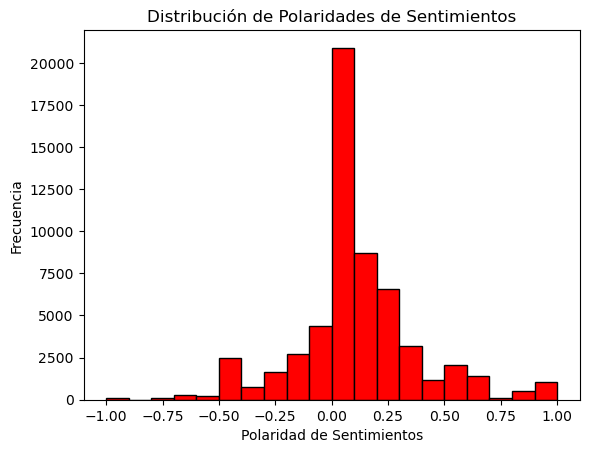

In [141]:
import matplotlib.pyplot as plt
#Se observala polaridad de los ssentimientos siendo -1 Negativo 0 Neutro y 1 Positivo, se observa que la mayoriase encuentramasalla de lo neutroo
plt.hist(ureviews["sentimientos"], bins=20, color='red', edgecolor='black')
plt.title('Distribución de Polaridades de Sentimientos')
plt.xlabel('Polaridad de Sentimientos')
plt.ylabel('Frecuencia')
plt.show()

In [142]:
ureviews["etiqueta_sentimiento"] = ureviews["sentimientos"].apply(asignar_etiqueta)

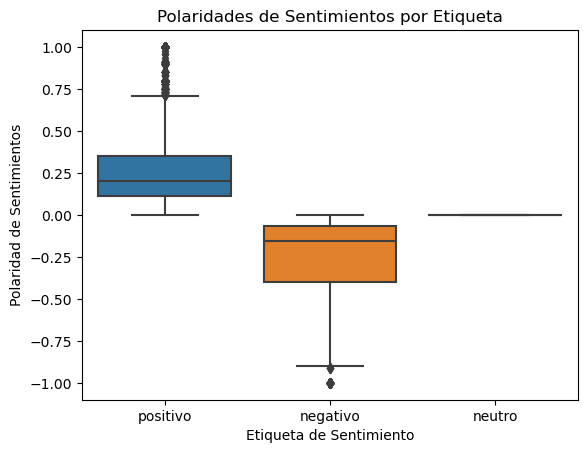

In [143]:
import seaborn as sns

sns.boxplot(x='etiqueta_sentimiento', y='sentimientos', data=ureviews)
plt.title('Polaridades de Sentimientos por Etiqueta')
plt.xlabel('Etiqueta de Sentimiento')
plt.ylabel('Polaridad de Sentimientos')
plt.show()

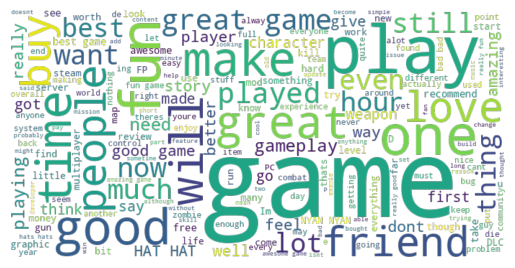

In [144]:
# Voy a crear una nube de palabras con WordCloud para eso tenbgo que:
# Concatenar todos los comentarios en una sola cadena
todos_comentarios = ' '.join(ureviews['review'])

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color=None, mode='RGBA').generate(todos_comentarios)

# Crear una imagen en blanco
blank_image = np.ones((400, 800, 4)) * 255  # RGBA image with all pixels set to white

# Superponer la nube de palabras en la imagen en blanco
for i in range(4):  # Copiar los canales RGB de la nube de palabras a la imagen en blanco
    blank_image[:, :, i] = wordcloud.to_array()[:, :, i]

# Visualizar la imagen resultante
plt.imshow(blank_image.astype(np.uint8), interpolation='bilinear')
plt.axis('off')
plt.show()  #La intencion es observar las palabras mas relevantes

In [145]:
ureviews

,user_id,item_id,recommend,review,anio_post,sentimientos,etiqueta_sentimiento
0,76561197970982479,1250,True,Simple yet with great replayability In my opin...,2011,0.174444,positivo
1,76561197970982479,22200,True,Its unique and worth a playthrough,2011,0.337500,positivo
2,76561197970982479,43110,True,Great atmosphere The gunplay can be a bit chun...,2011,0.075000,positivo
3,js41637,251610,True,I know what you think when you see this title ...,2014,0.114583,positivo
4,js41637,227300,True,For a simple its actually not all that simple ...,2013,-0.036111,negativo
...,...,...,...,...,...,...,...
58425,76561198312638244,70,True,a must have classic from steam definitely wort...,2014,0.233333,positivo
58426,76561198312638244,362890,True,this game is a perfect remake of the original ...,2014,0.142500,positivo
58427,LydiaMorley,273110,True,had so much fun plaing this and collecting res...,2014,0.087500,positivo
58428,LydiaMorley,730,True,D,2014,0.000000,neutro


In [146]:
ureviews.shape

(58430, 7)

In [147]:
ureviews.drop(['review'], axis=1,inplace=True)


In [148]:
sentiments_mapping = {"positivo": 1, "neutro": 0, "negativo": -1} #con los valores Negatico, neutro y positivo creo una columna numérica que va a servirme para mas adelante para analizar las variaciones entre esa, los sentimientos con valores decimales y las recomendaciones

# Crear una nueva columna 'sentiments_numerico' con valores numéricos
ureviews['sentiments'] = ureviews['etiqueta_sentimiento'].map(sentiments_mapping)

In [149]:
ureviews.drop(['etiqueta_sentimiento'], axis=1,inplace=True)
ureviews

,user_id,item_id,recommend,anio_post,sentimientos,sentiments
0,76561197970982479,1250,True,2011,0.174444,1
1,76561197970982479,22200,True,2011,0.337500,1
2,76561197970982479,43110,True,2011,0.075000,1
3,js41637,251610,True,2014,0.114583,1
4,js41637,227300,True,2013,-0.036111,-1
...,...,...,...,...,...,...
58425,76561198312638244,70,True,2014,0.233333,1
58426,76561198312638244,362890,True,2014,0.142500,1
58427,LydiaMorley,273110,True,2014,0.087500,1
58428,LydiaMorley,730,True,2014,0.000000,0


In [150]:
data_clean2 = 'Data/user_review.csv'
ureviews.to_csv(data_clean2, index=False,encoding='utf-8')

## Ahora comenzaremos a analizar y modificar el dataframe que surge del archivo 'australian_users_items.json'

In [151]:
uitems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   steam_id     88310 non-null  object
 3   user_url     88310 non-null  object
 4   items        88310 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


In [152]:
uitems.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


In [153]:
uitems.tail()

,user_id,items_count,steam_id,user_url,items
88305,76561198323066619,22,76561198323066619,http://steamcommunity.com/profiles/76561198323...,"[{'item_id': '413850', 'item_name': 'CS:GO Pla..."
88306,76561198326700687,177,76561198326700687,http://steamcommunity.com/profiles/76561198326...,"[{'item_id': '11020', 'item_name': 'TrackMania..."
88307,XxLaughingJackClown77xX,0,76561198328759259,http://steamcommunity.com/id/XxLaughingJackClo...,[]
88308,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"[{'item_id': '304930', 'item_name': 'Unturned'..."
88309,edward_tremethick,0,76561198331598578,http://steamcommunity.com/id/edward_tremethick,[]


In [154]:
uitems.shape

(88310, 5)

In [155]:
uitems.isnull().sum()

user_id        0
items_count    0
steam_id       0
user_url       0
items          0
dtype: int64

In [156]:
items_duplicate = duplicates(uitems, 'user_id')
items_duplicate

,user_id,items_count,steam_id,user_url,items
11000,05041129,35,76561198167088451,http://steamcommunity.com/id/05041129,"[{'item_id': '4000', 'item_name': 'Garry's Mod..."
29193,05041129,35,76561198167088451,http://steamcommunity.com/id/05041129,"[{'item_id': '4000', 'item_name': 'Garry's Mod..."
37062,10outof10matee,56,76561198050688208,http://steamcommunity.com/id/10outof10matee,"[{'item_id': '220', 'item_name': 'Half-Life 2'..."
37061,10outof10matee,56,76561198050688208,http://steamcommunity.com/id/10outof10matee,"[{'item_id': '220', 'item_name': 'Half-Life 2'..."
6167,111222333444555666888,52,76561198082607692,http://steamcommunity.com/id/11122233344455566...,"[{'item_id': '240', 'item_name': 'Counter-Stri..."
...,...,...,...,...,...
4625,youseeitnowgetout,5,76561198087136132,http://steamcommunity.com/id/youseeitnowgetout,"[{'item_id': '230410', 'item_name': 'Warframe'..."
3473,zandado,107,76561198057890701,http://steamcommunity.com/id/zandado,"[{'item_id': '20', 'item_name': 'Team Fortress..."
34176,zandado,107,76561198057890701,http://steamcommunity.com/id/zandado,"[{'item_id': '20', 'item_name': 'Team Fortress..."
12417,zeroblade,306,76561197970272666,http://steamcommunity.com/id/zeroblade,"[{'item_id': '18110', 'item_name': 'Shattered ..."


In [157]:
uitems = uitems.explode('items').reset_index(drop=True)

In [158]:
uitems_normalize = pd.json_normalize(uitems['items'])

In [159]:
uitems = pd.concat([uitems, uitems_normalize], axis=1)

In [160]:
uitems

,user_id,items_count,steam_id,user_url,items,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '10', 'item_name': 'Counter-Strike...",10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '20', 'item_name': 'Team Fortress ...",20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '30', 'item_name': 'Day of Defeat'...",30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '40', 'item_name': 'Deathmatch Cla...",40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '50', 'item_name': 'Half-Life: Opp...",50,Half-Life: Opposing Force,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5170010,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"{'item_id': '373330', 'item_name': 'All Is Dus...",373330,All Is Dust,0.0,0.0
5170011,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"{'item_id': '388490', 'item_name': 'One Way To...",388490,One Way To Die: Steam Edition,3.0,3.0
5170012,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"{'item_id': '521570', 'item_name': 'You Have 1...",521570,You Have 10 Seconds 2,4.0,4.0
5170013,76561198329548331,7,76561198329548331,http://steamcommunity.com/profiles/76561198329...,"{'item_id': '519140', 'item_name': 'Minds Eyes...",519140,Minds Eyes,3.0,3.0


In [161]:
uitems = uitems.drop(columns=['items', 'user_url', 'playtime_2weeks']) #Elimino columnas que no me sirven

In [162]:
uitems

,user_id,items_count,steam_id,item_id,item_name,playtime_forever
0,76561197970982479,277,76561197970982479,10,Counter-Strike,6.0
1,76561197970982479,277,76561197970982479,20,Team Fortress Classic,0.0
2,76561197970982479,277,76561197970982479,30,Day of Defeat,7.0
3,76561197970982479,277,76561197970982479,40,Deathmatch Classic,0.0
4,76561197970982479,277,76561197970982479,50,Half-Life: Opposing Force,0.0
...,...,...,...,...,...,...
5170010,76561198329548331,7,76561198329548331,373330,All Is Dust,0.0
5170011,76561198329548331,7,76561198329548331,388490,One Way To Die: Steam Edition,3.0
5170012,76561198329548331,7,76561198329548331,521570,You Have 10 Seconds 2,4.0
5170013,76561198329548331,7,76561198329548331,519140,Minds Eyes,3.0


In [163]:
uitems['item_name'].unique()

array(['Counter-Strike', 'Team Fortress Classic', 'Day of Defeat', ...,
       'ChaosTower', 'Aveyond 4: Shadow Of The Mist', 'Arachnophobia'],
      dtype=object)

In [164]:
uitems.duplicated().sum() 

59209

In [165]:
items_duplicates = uitems.duplicated()

In [166]:
items_duplicates


0          False
1          False
2          False
3          False
4          False
           ...  
5170010    False
5170011    False
5170012    False
5170013    False
5170014    False
Length: 5170015, dtype: bool

In [167]:
items_duplicate.count()

user_id        1357
items_count    1357
steam_id       1357
user_url       1357
items          1357
dtype: int64

In [168]:
uitems.duplicated(keep = 'first')
uitems

,user_id,items_count,steam_id,item_id,item_name,playtime_forever
0,76561197970982479,277,76561197970982479,10,Counter-Strike,6.0
1,76561197970982479,277,76561197970982479,20,Team Fortress Classic,0.0
2,76561197970982479,277,76561197970982479,30,Day of Defeat,7.0
3,76561197970982479,277,76561197970982479,40,Deathmatch Classic,0.0
4,76561197970982479,277,76561197970982479,50,Half-Life: Opposing Force,0.0
...,...,...,...,...,...,...
5170010,76561198329548331,7,76561198329548331,373330,All Is Dust,0.0
5170011,76561198329548331,7,76561198329548331,388490,One Way To Die: Steam Edition,3.0
5170012,76561198329548331,7,76561198329548331,521570,You Have 10 Seconds 2,4.0
5170013,76561198329548331,7,76561198329548331,519140,Minds Eyes,3.0


In [169]:
uitems.drop_duplicates(keep='first', inplace=True)

In [170]:
uitems.duplicated().sum() #Elimine todos los duplicados y lo corroboro

0

In [171]:
uitems.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110806 entries, 0 to 5170014
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   items_count       int64  
 2   steam_id          object 
 3   item_id           object 
 4   item_name         object 
 5   playtime_forever  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 272.9+ MB


In [172]:
uitems['playtime_forever'] = uitems['playtime_forever'].astype('Int64')

In [173]:
uitems['playtime_forever'].value_counts() #Observo estacoluman que luego me dará las horas y me serviran para los endpoints

0        1847730
1         101586
2          34391
3          31530
4          29127
          ...   
46463          1
34067          1
56816          1
25958          1
34753          1
Name: playtime_forever, Length: 48861, dtype: Int64

In [174]:
uitems

,user_id,items_count,steam_id,item_id,item_name,playtime_forever
0,76561197970982479,277,76561197970982479,10,Counter-Strike,6
1,76561197970982479,277,76561197970982479,20,Team Fortress Classic,0
2,76561197970982479,277,76561197970982479,30,Day of Defeat,7
3,76561197970982479,277,76561197970982479,40,Deathmatch Classic,0
4,76561197970982479,277,76561197970982479,50,Half-Life: Opposing Force,0
...,...,...,...,...,...,...
5170010,76561198329548331,7,76561198329548331,373330,All Is Dust,0
5170011,76561198329548331,7,76561198329548331,388490,One Way To Die: Steam Edition,3
5170012,76561198329548331,7,76561198329548331,521570,You Have 10 Seconds 2,4
5170013,76561198329548331,7,76561198329548331,519140,Minds Eyes,3


In [175]:
uitems['playtime_forever'] = uitems['playtime_forever']/60 #los divido por 60 intuyendo que estan en minutos

In [176]:
uitems

,user_id,items_count,steam_id,item_id,item_name,playtime_forever
0,76561197970982479,277,76561197970982479,10,Counter-Strike,0.1
1,76561197970982479,277,76561197970982479,20,Team Fortress Classic,0.0
2,76561197970982479,277,76561197970982479,30,Day of Defeat,0.116667
3,76561197970982479,277,76561197970982479,40,Deathmatch Classic,0.0
4,76561197970982479,277,76561197970982479,50,Half-Life: Opposing Force,0.0
...,...,...,...,...,...,...
5170010,76561198329548331,7,76561198329548331,373330,All Is Dust,0.0
5170011,76561198329548331,7,76561198329548331,388490,One Way To Die: Steam Edition,0.05
5170012,76561198329548331,7,76561198329548331,521570,You Have 10 Seconds 2,0.066667
5170013,76561198329548331,7,76561198329548331,519140,Minds Eyes,0.05


In [177]:
uitems['playtime_forever'] = round(uitems['playtime_forever'], 2) #reduzo la cantidad de decimales

In [178]:
uitems

,user_id,items_count,steam_id,item_id,item_name,playtime_forever
0,76561197970982479,277,76561197970982479,10,Counter-Strike,0.1
1,76561197970982479,277,76561197970982479,20,Team Fortress Classic,0.0
2,76561197970982479,277,76561197970982479,30,Day of Defeat,0.12
3,76561197970982479,277,76561197970982479,40,Deathmatch Classic,0.0
4,76561197970982479,277,76561197970982479,50,Half-Life: Opposing Force,0.0
...,...,...,...,...,...,...
5170010,76561198329548331,7,76561198329548331,373330,All Is Dust,0.0
5170011,76561198329548331,7,76561198329548331,388490,One Way To Die: Steam Edition,0.05
5170012,76561198329548331,7,76561198329548331,521570,You Have 10 Seconds 2,0.07
5170013,76561198329548331,7,76561198329548331,519140,Minds Eyes,0.05


In [179]:
uitems = uitems[uitems['playtime_forever'] != 0] #elimino los valores en 0

In [180]:
uitems['playtime_forever'].value_counts()

0.02      101586
0.03       34391
0.05       31530
0.07       29127
0.08       27612
           ...  
774.38         1
567.78         1
946.93         1
432.63         1
579.22         1
Name: playtime_forever, Length: 48860, dtype: Int64

In [181]:
uitems['items_count'] = uitems['items_count'].astype(object)

In [182]:
uitems.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3246362 entries, 0 to 5170013
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   items_count       object 
 2   steam_id          object 
 3   item_id           object 
 4   item_name         object 
 5   playtime_forever  Float64
dtypes: Float64(1), object(5)
memory usage: 176.5+ MB


In [183]:
uitems

,user_id,items_count,steam_id,item_id,item_name,playtime_forever
0,76561197970982479,277,76561197970982479,10,Counter-Strike,0.1
2,76561197970982479,277,76561197970982479,30,Day of Defeat,0.12
8,76561197970982479,277,76561197970982479,300,Day of Defeat: Source,78.88
9,76561197970982479,277,76561197970982479,240,Counter-Strike: Source,30.88
10,76561197970982479,277,76561197970982479,3830,Psychonauts,5.55
...,...,...,...,...,...,...
5170007,76561198329548331,7,76561198329548331,304930,Unturned,11.28
5170008,76561198329548331,7,76561198329548331,227940,Heroes & Generals,0.72
5170011,76561198329548331,7,76561198329548331,388490,One Way To Die: Steam Edition,0.05
5170012,76561198329548331,7,76561198329548331,521570,You Have 10 Seconds 2,0.07


In [184]:
data_clean3 = 'Data/user_items.csv'
uitems.to_csv(data_clean3, index= False, encoding='utf-8')